In [1]:
%reload_ext autoreload
%autoreload 2
%run startup.py

ag_ha = attrgetter(*'t v_0 v_c v_1 a_max'.split())
ag = attrgetter(*'x t v_0 v_c v_1 v_max a_max'.split())

def ch(v):
    for e in chain(*v):
        if e is not None:
            yield e

j = Joint(5_000, 50_000)
       
   

In [24]:
j = Joint(5_000, 50_000)
joints = [j]*2

sl = SegmentList(joints)  
x = 1000

sl.move([x,x/4])

b = sl[0][0]
print(b.t)
ss = b.iter_steps()

l= list(ss)
len(l)


0.30006518899294243


75017

<AxesSubplot:xlabel='t'>

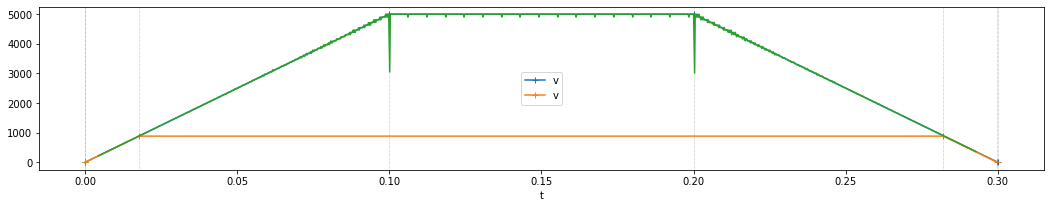

In [29]:
j = Joint(5_000, 50_000)
joints = [j]*2

sl = SegmentList(joints)  
x = 1000

sl.move([x,x/4])

ax = sl.plot()

b = sl[0][0]
t = pd.Series(list(s[1] for s in b.iter_steps()))
#ax = (t.rolling(500).mean()*(250_000)).plot(figsize=(20,3))

# Calculate velocity
x = t.to_frame('step')
x['t'] = 4/1e6
x['t'] = x.t.cumsum()
x = x[x.step==1]
v = (1/x.t.diff()).to_frame('v')
x = x.join(v)
x = x[x.v < 20_000]
x.set_index('t').v.plot(ax=ax)



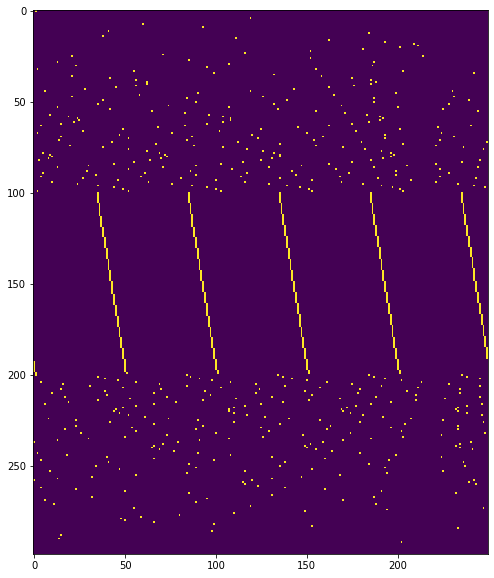

In [50]:
l = 299
last = l*(len(t)//l)
img = t.values[:last].reshape( (l,-1) )

from matplotlib import pyplot as plt
fig,ax = plt.subplots(1, figsize=(10,10))
ax.imshow(img, interpolation='nearest')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[0.0, 4.2426406871196026e-05, 5.727564927610875e-05, 7.778174593051951e-05, 0.0, 0.0]


0.2501|[0        249↗   750@4998  ↘0       5000] [0        249↗   750@4998  ↘0       5000]
0.2000|[5000      49↗   800@4473  ↘49      5000] [5000       0↗  1000@5000  ↘0       5000]
0.2000|[5000       0↗  1000@5000  ↘0       5000] [5000      99↗   600@3875  ↘99      5000]
0.2000|[5000     149↗   400@3165  ↘149     5000] [5000       0↗  1000@5000  ↘0       5000]
0.2000|[5000       0↗  1000@5000  ↘0       5000] [5000       0↗  1000@5000  ↘0       5000]
0.2501|[5000       0↗   750@4998  ↘249        0] [5000       0↗   750@4998  ↘249        0]

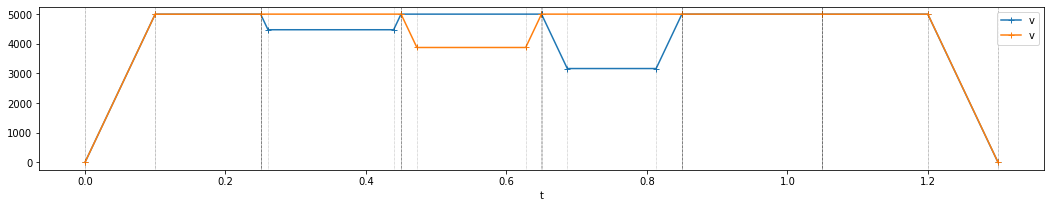

In [83]:
# Too many planning updates for sid=1.
%load_ext autoreload
%autoreload 2
%matplotlib inline
from trajectory.planner import Segment, SegmentList, Joint
from trajectory.gsolver import ACDBlock

j = Joint(5_000, 50_000)
joints = [j]*2

sl = SegmentList(joints)   
s = sl.move([1000,1000])
s = sl.move([900,1000])
s = sl.move([1000,800])
s = sl.move([700,1000])
s = sl.move([1000,1000])
s = sl.move([1000,1000])
sl.plot()
print([s.times_e_rms for  s in sl])
sl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[]
[(0, 4), (2, 4), (3, 3), (1, 1)]


<Figure size 432x288 with 0 Axes>

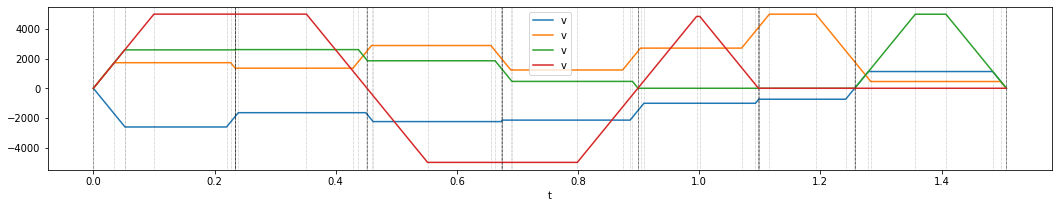

In [5]:
# Too many planning updates for sid=1.
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run startup.py

from trajectory.planner import Segment, SegmentList, Joint

j = Joint(5_000, 50_000)
joints = [j]*4

sl = SegmentList(joints)  

sl.move([-538, 372, 539, 920])
sl.move([-359, 308, 562, 838])
sl.move([-497, 631, 409, -861])
sl.move([-479, 298, 109, -874])
sl.move([-203, 557, 0, 495])
sl.move([-112, 683, 0, 0])
sl.move([257, 130, 751, 0])


sl.plot()

print([ (c.id, round(c.v_1), round(n.v_0)) for c, n in sl.discontinuities()])
print(Counter(sl.replans).most_common(10))

[]
[9.244457799136702e-05, 0.0002141232121933551, 7.527283706622979e-05, 0.0008038561749467238, 8.611620056644884e-05, 3.464823227813623e-05, 0.000825478043317918]
[(1, 5), (0, 1)]


<Figure size 432x288 with 0 Axes>

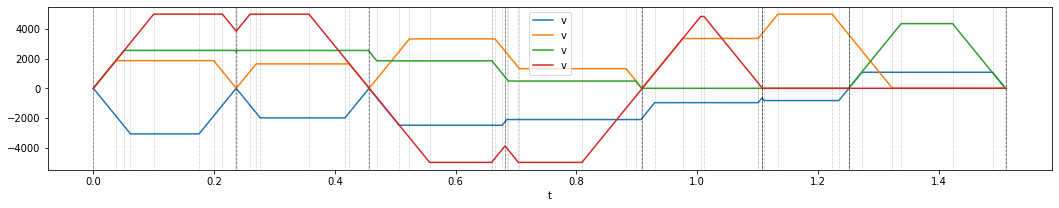

In [352]:
%run startup.py

from trajectory.planner import Segment, SegmentList, Joint

j = Joint(5_000, 50_000)
joints = [j]*4

sl = SegmentList(joints)  

sl.move([-538, 372, 539, 920])
sl.move([-359, 308, 562, 838])
sl.move([-497, 631, 409, -861])
sl.move([-479, 298, 109, -874])
sl.move([-203, 557, 0, 495])
sl.move([-112, 683, 0, 0])
sl.move([257, 130, 751, 0])

sl.plot()
print([ (c.id, round(c.v_1), round(n.v_0)) for c, n in sl.discontinuities()])
print([s.times_e_rms for s in sl])
print(Counter(sl.replans).most_common(10))

In [346]:
from trajectory.gsolver  import sign
def bent(prior, current):
    
    cd = current.d
    pd = prior.d
    
    s1 = sign(pd*prior.v_c-pd*prior.v_1)
    s2 = sign(cd*current.v_0-cd*current.v_c)
   
    return s1*s2 < 0

prior = sl[1,2]
current = sl[2,2]
print(bent(prior, current))
    
    

False


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

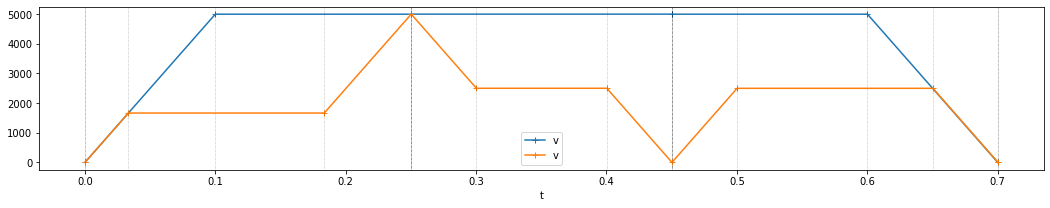

In [125]:
# Too many planning updates for sid=1.
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run startup.py
import matplotlib.pylab as plt
from trajectory.planner import Segment, SegmentList, Joint

j = Joint(5_000, 50_000)
joints = [j]*2

sl = SegmentList(joints)   
s = sl.move([1000,500])
s = sl.move([1000,500])
s = sl.move([1000,500])
sl.plot(); plt.show()

In [100]:
sl[1,3], sl[2,3]

([4998       0↗   838@4999  ↘0       4999],
 [0       -249↗  -611@4997  ↘0       4998])

In [107]:
prior, current = sl[1, 3], sl[2, 3]
prior.set_bv(v_1='mean', next_=current)  
current.set_bv(v_0='mean', prior=prior)
prior, current 

([4998       0↗   838@4999  ↘0          0],
 [0       -249↗  -611@4997  ↘0       4998])